In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np

import matplotlib.pyplot as plt

## Estructura base con Batchnorm y Ruido Gaussiano

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=data_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))
x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))

print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 1.0 - Min value: 0.0
Test set: 10000 samples - Max value: 1.0 - Min value: 0.0
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
# There are no GaussianNoise Layer in Pytorch
# https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x

In [ ]:
# Creating our Neural Network - Convolutional Blocks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = self._CBGN(3, 32)
        self.block2 = self._CBGN(32, 64)
        self.block3 = self._CBGN(64, 128)
        self.block4 = self._CBGN(128, 256)
        self.block5 = self._CBGN(256, 512)
        # Flatten at forward!
        self.features = nn.Linear(512, 512)
        self.reluFeatures = nn.ReLU()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.block1(x)  # 32x32 -> 16x16 @ 32
        out = self.block2(out)  # 16x16 -> 8x8 @ 64
        out = self.block3(out)  # 8x8 -> 4x4 @ 128
        out = self.block4(out)  # 4x4 -> 2x2 @ 256
        out = self.block5(out)  # 2x2 -> 1x1 @ 512
        out = out.view(out.size(0), -1)  # Flatten
        out = self.reluFeatures(self.features(out))  # 512 -> 512
        out = self.classifier(out)  # 512 -> num_classes (10)
        return out

    # DEF A BLOCK Conv + BN + GN + MaxPool
    def _CBGN(self, in_channels, filters):
        layers = []
        layers += [nn.Conv2d(in_channels, filters, kernel_size=(3, 3), padding=1)]
        layers += [nn.BatchNorm2d(filters)]
        layers += [GaussianNoise(0.3)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(kernel_size=(2, 2))]
        return nn.Sequential(*layers)

In [ ]:
# Instantiating the network and printing its architecture
net = Net().to(device)
print(net)

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GaussianNoise()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GaussianNoise()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GaussianNoise()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block4): S

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print("[Epoch {}] Train Loss: {:.6f} - Test Loss: {:.6f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
        epoch + 1, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] Train Loss: 0.013702 - Test Loss: 0.011984 - Train Accuracy: 49.93% - Test Accuracy: 58.41%
[Epoch 2] Train Loss: 0.009655 - Test Loss: 0.027617 - Train Accuracy: 65.43% - Test Accuracy: 32.12%
[Epoch 3] Train Loss: 0.008007 - Test Loss: 0.010627 - Train Accuracy: 71.77% - Test Accuracy: 63.61%
[Epoch 4] Train Loss: 0.007033 - Test Loss: 0.007526 - Train Accuracy: 75.33% - Test Accuracy: 73.53%
[Epoch 5] Train Loss: 0.006357 - Test Loss: 0.009661 - Train Accuracy: 77.48% - Test Accuracy: 68.39%
[Epoch 6] Train Loss: 0.005756 - Test Loss: 0.008957 - Train Accuracy: 79.73% - Test Accuracy: 70.47%
[Epoch 7] Train Loss: 0.005288 - Test Loss: 0.009319 - Train Accuracy: 81.42% - Test Accuracy: 69.27%
[Epoch 8] Train Loss: 0.004843 - Test Loss: 0.007528 - Train Accuracy: 83.07% - Test Accuracy: 74.24%
[Epoch 9] Train Loss: 0.004525 - Test Loss: 0.008913 - Train Accuracy: 83.99% - Test Accuracy: 71.53%
[Epoch 10] Train Loss: 0.004196 - Test Loss: 0.007204 - 

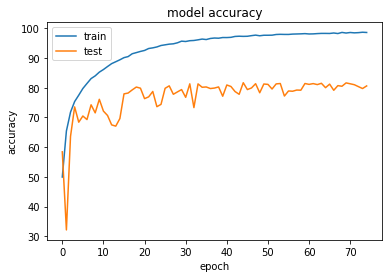

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## + Learning factor scheduler y Data Augmentation

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    # Otras versiones de data augmentation, con normalización
    torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  #Para la normalización del Data augmentation
                                                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                                  ])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))

print("Example batch shape: {}".format(x_batch.shape))

Files already downloaded and verified
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
# There are no GaussianNoise Layer in Pytorch
# https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x

In [ ]:
# Creating our Neural Network - Convolutional Blocks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = self._CBGN(3, 32)
        self.block2 = self._CBGN(32, 64)
        self.block3 = self._CBGN(64, 128)
        self.block4 = self._CBGN(128, 256)
        self.block5 = self._CBGN(256, 512)
        # Flatten at forward!
        self.features = nn.Linear(512, 512)
        self.reluFeatures = nn.ReLU()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.block1(x)  # 32x32 -> 16x16 @ 32
        out = self.block2(out)  # 16x16 -> 8x8 @ 64
        out = self.block3(out)  # 8x8 -> 4x4 @ 128
        out = self.block4(out)  # 4x4 -> 2x2 @ 256
        out = self.block5(out)  # 2x2 -> 1x1 @ 512
        out = out.view(out.size(0), -1)  # Flatten
        out = self.reluFeatures(self.features(out))  # 512 -> 512
        out = self.classifier(out)  # 512 -> num_classes (10)
        return out

    # DEF A BLOCK Conv + BN + GN + MaxPool
    def _CBGN(self, in_channels, filters):
        layers = []
        layers += [nn.Conv2d(in_channels, filters, kernel_size=(3, 3), padding=1)]
        layers += [nn.BatchNorm2d(filters)]
        layers += [GaussianNoise(0.3)]
        layers += [nn.ReLU()]
        #Podemos hacer varias convoluciones antes de maxpool
        layers += [nn.Conv2d(filters, filters, kernel_size=(3, 3), padding=1)]
        layers += [nn.BatchNorm2d(filters)]
        layers += [GaussianNoise(0.3)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(kernel_size=(2, 2))]
        return nn.Sequential(*layers)

In [ ]:
# Instantiating the network and printing its architecture
net = Net().to(device)
print(net)

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GaussianNoise()
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GaussianNoise()
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GaussianNoise()
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GaussianNoise()
    (7): ReLU()
    (8): MaxPool2d(kernel_size

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     at epoch < 25
# lr = 0.01    30 <= epoch < 50
# lr = 0.001   epoch >= 50
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
        ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.01634 - Test Loss: 0.01271 - Train Accuracy: 39.10% - Test Accuracy: 53.89%
[Epoch 2] LR: 0.100 - Train Loss: 0.01273 - Test Loss: 0.01117 - Train Accuracy: 54.12% - Test Accuracy: 59.84%
[Epoch 3] LR: 0.100 - Train Loss: 0.01121 - Test Loss: 0.01092 - Train Accuracy: 59.85% - Test Accuracy: 60.61%
[Epoch 4] LR: 0.100 - Train Loss: 0.01013 - Test Loss: 0.00934 - Train Accuracy: 64.08% - Test Accuracy: 67.97%
[Epoch 5] LR: 0.100 - Train Loss: 0.00934 - Test Loss: 0.00827 - Train Accuracy: 67.19% - Test Accuracy: 71.47%
[Epoch 6] LR: 0.100 - Train Loss: 0.00875 - Test Loss: 0.00792 - Train Accuracy: 69.21% - Test Accuracy: 72.15%
[Epoch 7] LR: 0.100 - Train Loss: 0.00826 - Test Loss: 0.00904 - Train Accuracy: 71.16% - Test Accuracy: 68.72%
[Epoch 8] LR: 0.100 - Train Loss: 0.00794 - Test Loss: 0.00718 - Train Accuracy: 72.16% - Test Accuracy: 74.59%
[Epoch 9] LR: 0.100 - Train Loss: 0.00758 - Test Loss: 0.00716 - Train Accurac

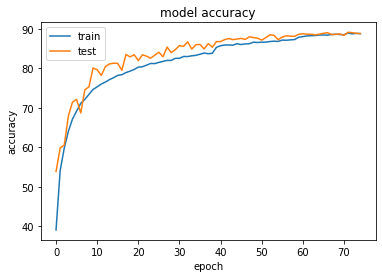

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Resnet18

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
# There are no GaussianNoise Layer in Pytorch
# https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x

In [ ]:
# Creating our Neural Network - ResNet18
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # resnet connection at forward

        # Initial convolution before resnet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        ########## 32x32@64
        # RESNET BLOCK 1
        self.b1_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b1_bn1 = nn.BatchNorm2d(64)
        self.b1_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b1_bn2 = nn.BatchNorm2d(64)
        # RESNET BLOCK 2
        self.b2_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2_bn1 = nn.BatchNorm2d(64)
        self.b2_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2_bn2 = nn.BatchNorm2d(64)

        ########## 16x16@128
        # RESNET BLOCK 3
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b3_shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )
        self.b3_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.b3_bn1 = nn.BatchNorm2d(128)
        self.b3_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b3_bn2 = nn.BatchNorm2d(128)
        # RESNET BLOCK 4
        self.b4_conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b4_bn1 = nn.BatchNorm2d(128)
        self.b4_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b4_bn2 = nn.BatchNorm2d(128)

        ########## 8x8@256
        # RESNET BLOCK 5
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b5_shortcut = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256)
        )
        self.b5_conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.b5_bn1 = nn.BatchNorm2d(256)
        self.b5_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b5_bn2 = nn.BatchNorm2d(256)
        # RESNET BLOCK 6
        self.b6_conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b6_bn1 = nn.BatchNorm2d(256)
        self.b6_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b6_bn2 = nn.BatchNorm2d(256)

        ########## 4x4@512
        # RESNET BLOCK 7
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b7_shortcut = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512)
        )
        self.b7_conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.b7_bn1 = nn.BatchNorm2d(512)
        self.b7_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b7_bn2 = nn.BatchNorm2d(512)
        # RESNET BLOCK 8
        self.b8_conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b8_bn1 = nn.BatchNorm2d(512)
        self.b8_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b8_bn2 = nn.BatchNorm2d(512)

        ########## 1x1@512
        # Final pooling
        self.average_pooling = nn.AvgPool2d(4)

        ########## 512@num_classes
        # To connect to the number of classes
        self.Linear = nn.Linear(512, num_classes)

    def forward(self, x):
        #### 32x32@3 -> 32x32@64
        # 0. Initial convolution ==> 
        x = F.relu(self.bn1(self.conv1(x)))

        #### 32x32@64 -> 32x32@64
        # 1. First ResNet block
        b1_1 = F.relu(self.b1_bn1(self.b1_conv1(x)))
        b1_2 = self.b1_bn2(self.b1_conv2(b1_1))
        out1 = F.relu(x + b1_2)  # resnet connection plus activation
        # 2. Second ResNet block
        b2_1 = F.relu(self.b2_bn1(self.b2_conv1(out1)))
        b2_2 = self.b2_bn2(self.b2_conv2(b2_1))
        out2 = F.relu(out1 + b2_2)  # resnet connection plus activation

        #### 32x32@64 -> 16x16@128
        # 3. Third ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b3_shortcut(out2)
        b3_1 = F.relu(self.b3_bn1(self.b3_conv1(out2)))
        b3_2 = self.b3_bn2(self.b3_conv2(b3_1))
        out3 = F.relu(shortcut + b3_2)  # resnet connection plus activation
        # 4. Fourth ResNet block
        b4_1 = F.relu(self.b4_bn1(self.b4_conv1(out3)))
        b4_2 = self.b4_bn2(self.b4_conv2(b4_1))
        out4 = F.relu(out3 + b4_2)  # resnet connection plus activation

        #### 16x16@128 -> 8x8@256
        # 5. Fifth ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b5_shortcut(out4)
        b5_1 = F.relu(self.b5_bn1(self.b5_conv1(out4)))
        b5_2 = self.b5_bn2(self.b5_conv2(b5_1))
        out5 = F.relu(shortcut + b5_2)  # resnet connection plus activation
        # 6. Sixth ResNet block
        b6_1 = F.relu(self.b6_bn1(self.b6_conv1(out5)))
        b6_2 = self.b6_bn2(self.b6_conv2(b6_1))
        out6 = F.relu(out5 + b6_2)  # resnet connection plus activation

        #### 8x8@256 -> 4x4@512
        # 7. Seventh ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b7_shortcut(out6)
        b7_1 = F.relu(self.b7_bn1(self.b7_conv1(out6)))
        b7_2 = self.b7_bn2(self.b7_conv2(b7_1))
        out7 = F.relu(shortcut + b7_2)  # resnet connection plus activation
        # 8. Eigth ResNet block
        b8_1 = F.relu(self.b8_bn1(self.b8_conv1(out7)))
        b8_2 = self.b8_bn2(self.b8_conv2(b8_1))
        out8 = F.relu(out7 + b8_2)  # resnet connection plus activation

        #### 4x4@512 -> 1x1@512
        pool_out = self.average_pooling(out8)

        #### 512 -> num_classes
        fc_out = self.Linear(pool_out.view(pool_out.size(0), -1))

        return fc_out

In [ ]:
# Instantiating the network and printing its architecture
net = ResNet18().to(device)
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b1_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (b1_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (b1_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (b2_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (b2_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3_shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), str

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.01670 - Test Loss: 0.01404 - Train Accuracy: 38.42% - Test Accuracy: 50.11%
[Epoch 2] LR: 0.100 - Train Loss: 0.01226 - Test Loss: 0.01149 - Train Accuracy: 55.88% - Test Accuracy: 59.46%
[Epoch 3] LR: 0.100 - Train Loss: 0.01021 - Test Loss: 0.00965 - Train Accuracy: 63.82% - Test Accuracy: 66.98%
[Epoch 4] LR: 0.100 - Train Loss: 0.00881 - Test Loss: 0.00865 - Train Accuracy: 69.11% - Test Accuracy: 70.18%
[Epoch 5] LR: 0.100 - Train Loss: 0.00780 - Test Loss: 0.00801 - Train Accuracy: 72.60% - Test Accuracy: 71.80%
[Epoch 6] LR: 0.100 - Train Loss: 0.00703 - Test Loss: 0.00719 - Train Accuracy: 75.58% - Test Accuracy: 75.41%
[Epoch 7] LR: 0.100 - Train Loss: 0.00652 - Test Loss: 0.00606 - Train Accuracy: 77.40% - Test Accuracy: 79.43%
[Epoch 8] LR: 0.100 - Train Loss: 0.00600 - Test Loss: 0.00622 - Train Accuracy: 79.07% - Test Accuracy: 79.43%
[Epoch 9] LR: 0.100 - Train Loss: 0.00562 - Test Loss: 0.00562 - Train Accurac

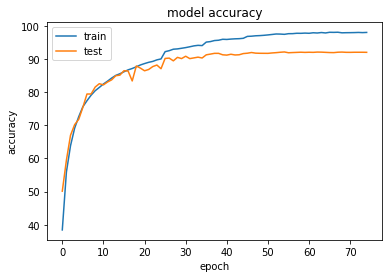

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-11

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
# There are no GaussianNoise Layer in Pytorch
# https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x

In [ ]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=num_classes ),
            # nn.ReLU(),
            # nn.Dropout2d(0.5),
            # nn.Linear(in_features=4096, out_features=4096),
            # nn.ReLU(),
            # nn.Dropout2d(0.5),
            # nn.Linear(in_features=4096, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG11().to(device)
print(net)

VGG11(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.01982 - Test Loss: 0.01738 - Train Accuracy: 31.81% - Test Accuracy: 41.14%
[Epoch 2] LR: 0.100 - Train Loss: 0.01390 - Test Loss: 0.01576 - Train Accuracy: 50.09% - Test Accuracy: 52.00%
[Epoch 3] LR: 0.100 - Train Loss: 0.01165 - Test Loss: 0.01084 - Train Accuracy: 58.44% - Test Accuracy: 64.02%
[Epoch 4] LR: 0.100 - Train Loss: 0.01010 - Test Loss: 0.00966 - Train Accuracy: 64.29% - Test Accuracy: 67.77%
[Epoch 5] LR: 0.100 - Train Loss: 0.00910 - Test Loss: 0.00944 - Train Accuracy: 67.95% - Test Accuracy: 68.46%
[Epoch 6] LR: 0.100 - Train Loss: 0.00831 - Test Loss: 0.00846 - Train Accuracy: 70.99% - Test Accuracy: 72.51%
[Epoch 7] LR: 0.100 - Train Loss: 0.00773 - Test Loss: 0.00749 - Train Accuracy: 73.05% - Test Accuracy: 74.03%
[Epoch 8] LR: 0.100 - Train Loss: 0.00725 - Test Loss: 0.00741 - Train Accuracy: 74.56% - Test Accuracy: 74.95%
[Epoch 9] LR: 0.100 - Train Loss: 0.00685 - Test Loss: 0.00793 - Train Accurac

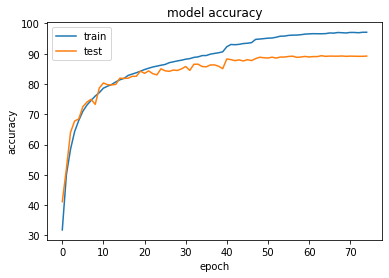

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-16

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG16().to(device)
print(net)

VGG18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.01831 - Test Loss: 0.01526 - Train Accuracy: 29.39% - Test Accuracy: 41.22%
[Epoch 2] LR: 0.100 - Train Loss: 0.01501 - Test Loss: 0.01225 - Train Accuracy: 45.22% - Test Accuracy: 56.50%
[Epoch 3] LR: 0.100 - Train Loss: 0.01296 - Test Loss: 0.01142 - Train Accuracy: 55.31% - Test Accuracy: 60.75%
[Epoch 4] LR: 0.100 - Train Loss: 0.01150 - Test Loss: 0.00920 - Train Accuracy: 61.26% - Test Accuracy: 68.52%
[Epoch 5] LR: 0.100 - Train Loss: 0.01049 - Test Loss: 0.00804 - Train Accuracy: 65.36% - Test Accuracy: 72.78%
[Epoch 6] LR: 0.100 - Train Loss: 0.00967 - Test Loss: 0.00813 - Train Accuracy: 68.31% - Test Accuracy: 72.71%
[Epoch 7] LR: 0.100 - Train Loss: 0.00900 - Test Loss: 0.00737 - Train Accuracy: 70.68% - Test Accuracy: 75.10%
[Epoch 8] LR: 0.100 - Train Loss: 0.00850 - Test Loss: 0.00708 - Train Accuracy: 72.60% - Test Accuracy: 76.94%
[Epoch 9] LR: 0.100 - Train Loss: 0.00810 - Test Loss: 0.00819 - Train Accurac

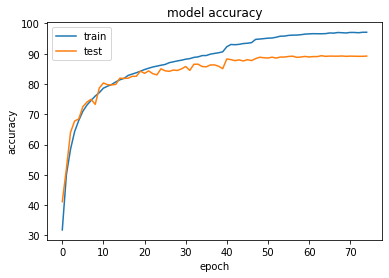

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-16 con cutout

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """

        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Cutout(n_holes=1, length=8)
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

Files already downloaded and verified
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG16().to(device)
print(net)

VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.01763 - Test Loss: 0.01556 - Train Accuracy: 31.76% - Test Accuracy: 40.64%
[Epoch 2] LR: 0.100 - Train Loss: 0.01377 - Test Loss: 0.01485 - Train Accuracy: 50.39% - Test Accuracy: 52.49%
[Epoch 3] LR: 0.100 - Train Loss: 0.01132 - Test Loss: 0.00961 - Train Accuracy: 61.73% - Test Accuracy: 66.67%
[Epoch 4] LR: 0.100 - Train Loss: 0.00982 - Test Loss: 0.00801 - Train Accuracy: 67.57% - Test Accuracy: 72.95%
[Epoch 5] LR: 0.100 - Train Loss: 0.00876 - Test Loss: 0.00771 - Train Accuracy: 71.39% - Test Accuracy: 74.19%
[Epoch 6] LR: 0.100 - Train Loss: 0.00803 - Test Loss: 0.00651 - Train Accuracy: 74.09% - Test Accuracy: 77.44%
[Epoch 7] LR: 0.100 - Train Loss: 0.00738 - Test Loss: 0.00698 - Train Accuracy: 76.61% - Test Accuracy: 76.30%
[Epoch 8] LR: 0.100 - Train Loss: 0.00693 - Test Loss: 0.00681 - Train Accuracy: 77.90% - Test Accuracy: 78.61%
[Epoch 9] LR: 0.100 - Train Loss: 0.00647 - Test Loss: 0.00547 - Train Accurac

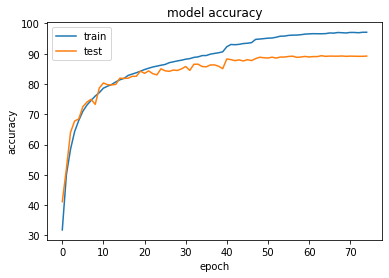

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-16 con mixup

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG16().to(device)
print(net)

VGG18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1, True)
        #inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.02040 - Test Loss: 0.01547 - Train Accuracy: 20.55% - Test Accuracy: 42.84%
[Epoch 2] LR: 0.100 - Train Loss: 0.01862 - Test Loss: 0.01325 - Train Accuracy: 29.64% - Test Accuracy: 54.03%
[Epoch 3] LR: 0.100 - Train Loss: 0.01718 - Test Loss: 0.01122 - Train Accuracy: 35.42% - Test Accuracy: 64.64%
[Epoch 4] LR: 0.100 - Train Loss: 0.01637 - Test Loss: 0.01038 - Train Accuracy: 37.42% - Test Accuracy: 69.31%
[Epoch 5] LR: 0.100 - Train Loss: 0.01569 - Test Loss: 0.01009 - Train Accuracy: 38.13% - Test Accuracy: 69.04%
[Epoch 6] LR: 0.100 - Train Loss: 0.01541 - Test Loss: 0.00901 - Train Accuracy: 39.47% - Test Accuracy: 75.59%
[Epoch 7] LR: 0.100 - Train Loss: 0.01494 - Test Loss: 0.00879 - Train Accuracy: 40.37% - Test Accuracy: 78.12%
[Epoch 8] LR: 0.100 - Train Loss: 0.01456 - Test Loss: 0.00862 - Train Accuracy: 41.29% - Test Accuracy: 77.39%
[Epoch 9] LR: 0.100 - Train Loss: 0.01421 - Test Loss: 0.00821 - Train Accurac

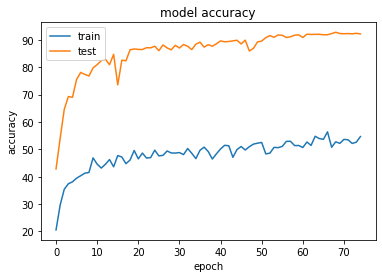

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-16 con cutout y mixup

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """

        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Cutout(n_holes=1, length=8)
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG16().to(device)
print(net)

VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) 

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1, True)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.02035 - Test Loss: 0.01564 - Train Accuracy: 22.00% - Test Accuracy: 43.96%
[Epoch 2] LR: 0.100 - Train Loss: 0.01833 - Test Loss: 0.01332 - Train Accuracy: 29.84% - Test Accuracy: 56.69%
[Epoch 3] LR: 0.100 - Train Loss: 0.01718 - Test Loss: 0.01078 - Train Accuracy: 33.75% - Test Accuracy: 65.64%
[Epoch 4] LR: 0.100 - Train Loss: 0.01667 - Test Loss: 0.01067 - Train Accuracy: 36.62% - Test Accuracy: 66.70%
[Epoch 5] LR: 0.100 - Train Loss: 0.01611 - Test Loss: 0.01052 - Train Accuracy: 37.21% - Test Accuracy: 71.24%
[Epoch 6] LR: 0.100 - Train Loss: 0.01560 - Test Loss: 0.00945 - Train Accuracy: 38.45% - Test Accuracy: 74.01%
[Epoch 7] LR: 0.100 - Train Loss: 0.01534 - Test Loss: 0.00907 - Train Accuracy: 38.23% - Test Accuracy: 74.19%
[Epoch 8] LR: 0.100 - Train Loss: 0.01500 - Test Loss: 0.00897 - Train Accuracy: 42.41% - Test Accuracy: 74.72%
[Epoch 9] LR: 0.100 - Train Loss: 0.01486 - Test Loss: 0.00751 - Train Accurac

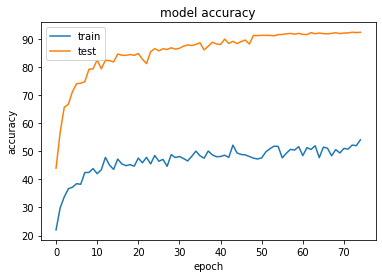

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VGG-16 con CutMix

In [ ]:
# Constants definition
batch_size = 100
num_classes = 10
epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations + Scalation
# https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(1.0, 1.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set: 50000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Test set: 10000 samples - Max value: 2.7537312507629395 - Min value: -2.429065704345703
Example batch shape: torch.Size([100, 3, 32, 32])


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = VGG16().to(device)
print(net)

VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

In [ ]:
# mismo criterio que mixup
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Para el cutmix en el train
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2   

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [ ]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # generate mixed sample
        lam = np.random.beta(1, 1) # en mixup era 1,1. Valores entre 0 y 1.
        rand_index = torch.randperm(inputs.size()[0]).cuda()
        targets_a = targets
        targets_b = targets[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
    ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # si usamos plateau como lr scheduler

print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.02084 - Test Loss: 0.01634 - Train Accuracy: 22.76% - Test Accuracy: 36.19%
[Epoch 2] LR: 0.100 - Train Loss: 0.01919 - Test Loss: 0.01327 - Train Accuracy: 32.94% - Test Accuracy: 52.74%
[Epoch 3] LR: 0.100 - Train Loss: 0.01811 - Test Loss: 0.01229 - Train Accuracy: 40.37% - Test Accuracy: 59.17%
[Epoch 4] LR: 0.100 - Train Loss: 0.01733 - Test Loss: 0.01010 - Train Accuracy: 45.40% - Test Accuracy: 66.95%
[Epoch 5] LR: 0.100 - Train Loss: 0.01702 - Test Loss: 0.00998 - Train Accuracy: 46.17% - Test Accuracy: 70.51%
[Epoch 6] LR: 0.100 - Train Loss: 0.01643 - Test Loss: 0.01021 - Train Accuracy: 49.75% - Test Accuracy: 68.89%
[Epoch 7] LR: 0.100 - Train Loss: 0.01604 - Test Loss: 0.00976 - Train Accuracy: 50.82% - Test Accuracy: 72.16%
[Epoch 8] LR: 0.100 - Train Loss: 0.01588 - Test Loss: 0.00877 - Train Accuracy: 51.62% - Test Accuracy: 75.60%
[Epoch 9] LR: 0.100 - Train Loss: 0.01544 - Test Loss: 0.00764 - Train Accurac

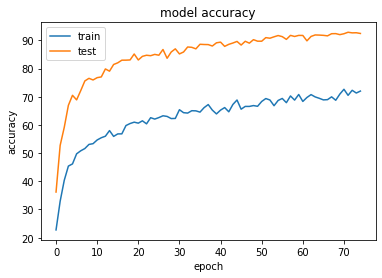

In [ ]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()